#SYED USMAN ALI SHAH#
##386543
##BSCS11-A

# Lab 8-Semantic Image Segmentation

Semantic segmentation is a computer vision technique that involves dividing an image into meaningful and coherent segments or regions based on their semantic properties such as object, background, and foreground. Unlike simple image segmentation techniques that group pixels based on their color, texture, or intensity, semantic segmentation goes further by associating each segment with a semantic label that represents the class or category of the object that it belongs to.

The objective of semantic segmentation is to create a precise pixel-level map of the image that assigns a unique label to each pixel based on its semantic content. This technique has many applications in computer vision, including object recognition, scene understanding, and autonomous navigation.

To achieve semantic segmentation, deep learning models like Fully Convolutional Neural Networks (FCN), U-Net, and SegNet have been developed. These models use a combination of convolutional neural networks (CNN) and upsampling techniques to produce a pixel-level segmentation of an input image. The training of these models involves feeding a large dataset of annotated images into the network, which learns to extract features and make semantic predictions.

Overall, semantic segmentation is a powerful tool in computer vision that enables machines to interpret images at a higher level of abstraction, allowing for more advanced applications in fields like self-driving cars, robotics, and medical imaging.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

# Cars Segmentation Dataset

This is a sample semantic image segmentation dataset. It contains images of cars and their segmentation masks. Most of the images were taken from side of the car. Image and its corresponding mask have the same name. For example, 003.png in the "masks" folder corresponds to the 003.png file in the "images" folder. Each pixel in a mask shows the class of the corresponding pixel in the corresponding image. For example, if value of pixel (3, 7) is 1, it means pixel (3,7) in the corresponding image belongs to class 1. We have following 5 classes in this dataset:

- 0 - background
- 1 - car
- 2 - wheel
- 3 - light
- 4 - windows

https://www.kaggle.com/datasets/intelecai/car-segmentation

In [2]:
!gdown https://drive.google.com/file/d/16rHJLc73PtBFyyAlfQqqGt3ZeEj4hikb/view?usp=sharing --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=16rHJLc73PtBFyyAlfQqqGt3ZeEj4hikb
From (redirected): https://drive.google.com/uc?id=16rHJLc73PtBFyyAlfQqqGt3ZeEj4hikb&confirm=t&uuid=6e139f19-80a9-44bb-98f3-a2400203eaed
To: /content/car-segmentation.zip
100% 463M/463M [00:02<00:00, 205MB/s]


In [3]:
%%capture
!unzip /content/car-segmentation.zip

### Question 1: In the cell below, paths to the images and their corresponding masks are being set. Please analyse the mask of an image and check how does it store the information regarding classes (i.e. different parts) of a vehicle?

In [4]:
IMAGE_PATH = "/content/car-segmentation/images/"
MASK_PATH = "/content/car-segmentation/masks/"

In [5]:
n_classes = 5
name = []
def create_df():
    #name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  211


In [6]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  160
Val Size     :  29
Test Size    :  22


In [7]:
import matplotlib
print(matplotlib.rcParams['image.cmap'])

viridis


Image Size (750, 1000, 3)
Mask Size (750, 1000)


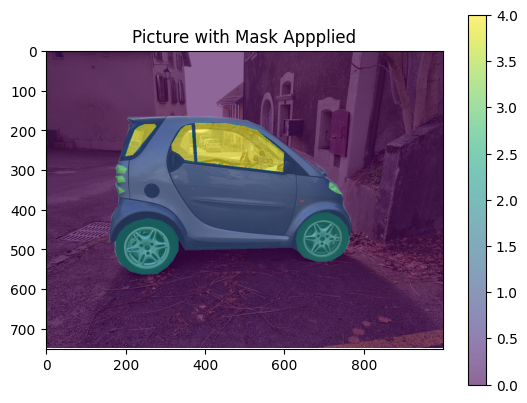

In [8]:
img = Image.open(IMAGE_PATH + '/' + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + '/' + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img, cmap = 'viridis')
msk = plt.imshow(mask, alpha=0.6, cmap ='viridis')
plt.title('Picture with Mask Appplied')
#plt.show()

# Add a colorbar to show the mapping between colors and data values
plt.colorbar(msk)

# Show the plot
plt.show()

### Question 2.1: Please observe the dataset class given in the cell below. When we want to retrieve items using an instance of this class, which function is generally called?

### Question 2.2: What does the data consist of that we obtain when we use an instance of this class for item retreival?

Answer 2.1:
The __getitem__ method is called to retrieve items using an instance of the CarDataset class. This method is responsible for returning the image and its corresponding mask when an index is passed to the dataset instance.

Answer 2.2:
When you use an instance of the CarDataset class for item retrieval, you obtain a tuple containing two elements:

The first element is the preprocessed image data, which has undergone transformations such as conversion to RGB format (if needed), resizing, normalization, and conversion to a tensor. This data is represented by the variable img.

The second element is the mask corresponding to the image to identify regions of interest within an image. In this dataset, the mask is represented by the variable mask.

In [9]:
from torchvision import transforms as T

class CarDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        return img, mask

### Question 3: In the cell below, from where did we pick up the values of mean and std of RGB values for input normalization?

The values of `mean` and `std` for RGB input normalization, which are `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` respectively, are commonly used in pre-trained models such as those available in the torchvision library. These values are derived from statistics calculated over the ImageNet dataset, which is a large-scale dataset commonly used for training and evaluating deep learning models for image classification.

The values are chosen to normalize the RGB pixel values of images in a way that aligns with the statistics of the ImageNet dataset, helping the model generalize better when using pre-trained weights or when transferring learning from models trained on ImageNet.

So, while the exact origin of these values might not be explicitly mentioned in the code snippet you provided, they are widely used as standard normalization values for many computer vision tasks, especially when leveraging pre-trained models or common practices in the field.

### Question 4: Which augmentations are we using in this case?

In the provided code snippet, the following augmentations are being used:

1. Resize: Images are resized to a target size of 256x256 pixels using `A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)`. This ensures that all images in the dataset have the same dimensions.

2. HorizontalFlip and VerticalFlip: These augmentations are applied to the training set using `A.HorizontalFlip()` and `A.VerticalFlip()`, respectively. HorizontalFlip flips the images horizontally, while VerticalFlip flips them vertically. These augmentations help increase the diversity of the training data.

3. GaussNoise: Gaussian noise is added to the images in the training set using `A.GaussNoise()`. This augmentation can help the model become more robust to noisy or distorted images during training.

So, the augmentations used in this case include resizing, horizontal flipping, vertical flipping, and adding Gaussian noise to the images in the training dataset.

In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

#datasets
train_set = CarDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = CarDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

#dataloader
batch_size= 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Models

# Segnet

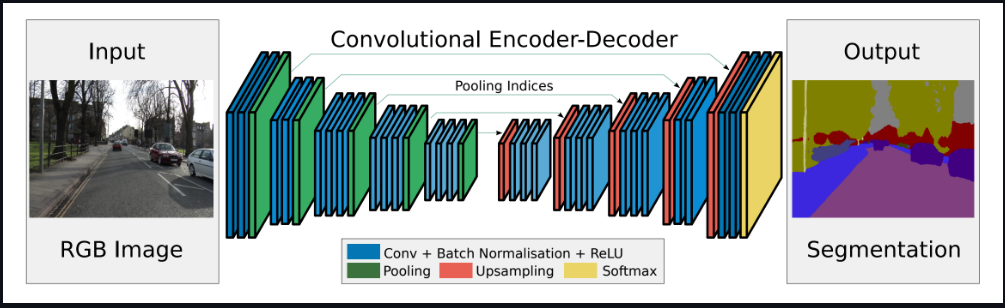

## Question 5: Please observe the SegNet model below and answer the following questions:

### 5.1: In SegNet we studied that during MaxPooling, the indices of the maxpooled values are stored during encoding stage and these values are then used in unpooling operations in the decoding stage. How is this being done in the code below? Which functions are being used in this process?

### 5.2: How many convolution blocks or stages are being used in the encoder and the decoder?

### 5.3: End the end of it all, what does the **dim=1** in **x = F.softmax(x, dim=1)** signify?

**5.1:**
In the provided code, the pooling indices are stored during the encoding stage using `nn.MaxPool2d` with `return_indices=True`. These indices are then used in the decoding stage for unpooling operations using `nn.MaxUnpool2d` along with the stored indices.

Specifically, in the `forward` method of the `SegNet` class:

- In the encoding layers, after each max pooling operation (`self.MaxEn`), the indices are returned (`ind1`, `ind2`, `ind3`, `ind4`, `ind5`) along with the pooled output `x`.
- In the decoding layers, the unpooling operations are performed using `self.MaxDe` along with the stored indices `ind1`, `ind2`, `ind3`, `ind4`, `ind5`. For example:
  - `x = self.MaxDe(x, ind5, output_size=size4)` corresponds to unpooling in Stage 5.
  - `x = self.MaxDe(x, ind4, output_size=size3)` corresponds to unpooling in Stage 4.
  - `x = self.MaxDe(x, ind3, output_size=size2)` corresponds to unpooling in Stage 3.
  - `x = self.MaxDe(x, ind2, output_size=size1)` corresponds to unpooling in Stage 2.
  - `x = self.MaxDe(x, ind1)` corresponds to unpooling in Stage 1.

So, the `nn.MaxPool2d` with `return_indices=True` is used for pooling during encoding, and `nn.MaxUnpool2d` is used with the stored indices for unpooling during decoding in SegNet.

**5.2:**
In the SegNet architecture implemented in the provided code, there are 5 convolution blocks or stages in both the encoder and decoder.

- **Encoder**:
  1. Stage 1: 2 convolution layers (`self.ConvEn11` and `self.ConvEn12`) followed by pooling (`self.MaxEn`).
  2. Stage 2: 2 convolution layers (`self.ConvEn21` and `self.ConvEn22`) followed by pooling (`self.MaxEn`).
  3. Stage 3: 3 convolution layers (`self.ConvEn31`, `self.ConvEn32`, and `self.ConvEn33`) followed by pooling (`self.MaxEn`).
  4. Stage 4: 3 convolution layers (`self.ConvEn41`, `self.ConvEn42`, and `self.ConvEn43`) followed by pooling (`self.MaxEn`).
  5. Stage 5: 3 convolution layers (`self.ConvEn51`, `self.ConvEn52`, and `self.ConvEn53`) followed by pooling (`self.MaxEn`).

- **Decoder**:
  1. Stage 5: Unpooling (`self.MaxDe`) followed by 3 convolution layers (`self.ConvDe53`, `self.ConvDe52`, and `self.ConvDe51`).
  2. Stage 4: Unpooling (`self.MaxDe`) followed by 3 convolution layers (`self.ConvDe43`, `self.ConvDe42`, and `self.ConvDe41`).
  3. Stage 3: Unpooling (`self.MaxDe`) followed by 3 convolution layers (`self.ConvDe33`, `self.ConvDe32`, and `self.ConvDe31`).
  4. Stage 2: Unpooling (`self.MaxDe`) followed by 2 convolution layers (`self.ConvDe22` and `self.ConvDe21`).
  5. Stage 1: Unpooling (`self.MaxDe`) followed by 2 convolution layers (`self.ConvDe12` and `self.ConvDe11`).

Each convolution block in both the encoder and decoder consists of multiple convolution layers followed by batch normalization layers (`self.BNEn*` and `self.BNDe*` respectively), except for the first and last stages in the decoder where there are only convolution layers without batch normalization.

Therefore, there are 5 convolution blocks or stages in both the encoder and decoder of the SegNet architecture as implemented in the provided code.

**5.3:**
In the line `x = F.softmax(x, dim=1)`, the `dim=1` argument specifies the dimension along which the softmax operation is applied. Specifically, it indicates that the softmax function should be applied along the channel dimension (dimension index 1 in PyTorch's tensor representation).

In the context of the SegNet architecture or any neural network dealing with image segmentation or classification tasks, the output tensor `x` typically has a shape of `[batch_size, num_classes, height, width]`. Here's what each dimension represents:

- `batch_size`: Number of samples in the batch.
- `num_classes`: Number of classes or channels in the output (e.g., for semantic segmentation, this would be the number of distinct labels).
- `height` and `width`: Spatial dimensions of the output feature map.

By specifying `dim=1`, the softmax operation is applied independently along the channel dimension for each spatial location in the output feature map. This is crucial for tasks like image segmentation or classification because it ensures that the softmax is applied separately to the scores or logits corresponding to each class at every pixel location in the image.

In simpler terms, `dim=1` ensures that the softmax operation normalizes the scores or logits for each pixel across all the classes, producing a probability distribution over the classes for each pixel location in the output.

In [11]:
import torch.nn.functional as F


class SegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=32, BN_momentum=0.5):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2)

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x)))
        x = F.relu(self.BNEn12(self.ConvEn12(x)))
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x)))
        x = F.relu(self.BNEn22(self.ConvEn22(x)))
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x)))
        x = F.relu(self.BNEn32(self.ConvEn32(x)))
        x = F.relu(self.BNEn33(self.ConvEn33(x)))
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x)))
        x = F.relu(self.BNEn42(self.ConvEn42(x)))
        x = F.relu(self.BNEn43(self.ConvEn43(x)))
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x)))
        x = F.relu(self.BNEn52(self.ConvEn52(x)))
        x = F.relu(self.BNEn53(self.ConvEn53(x)))
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        x = F.softmax(x, dim=1)

        return x


model = SegNet(3,5)

# https://github.com/vinceecws/SegNet_PyTorch

## UNet

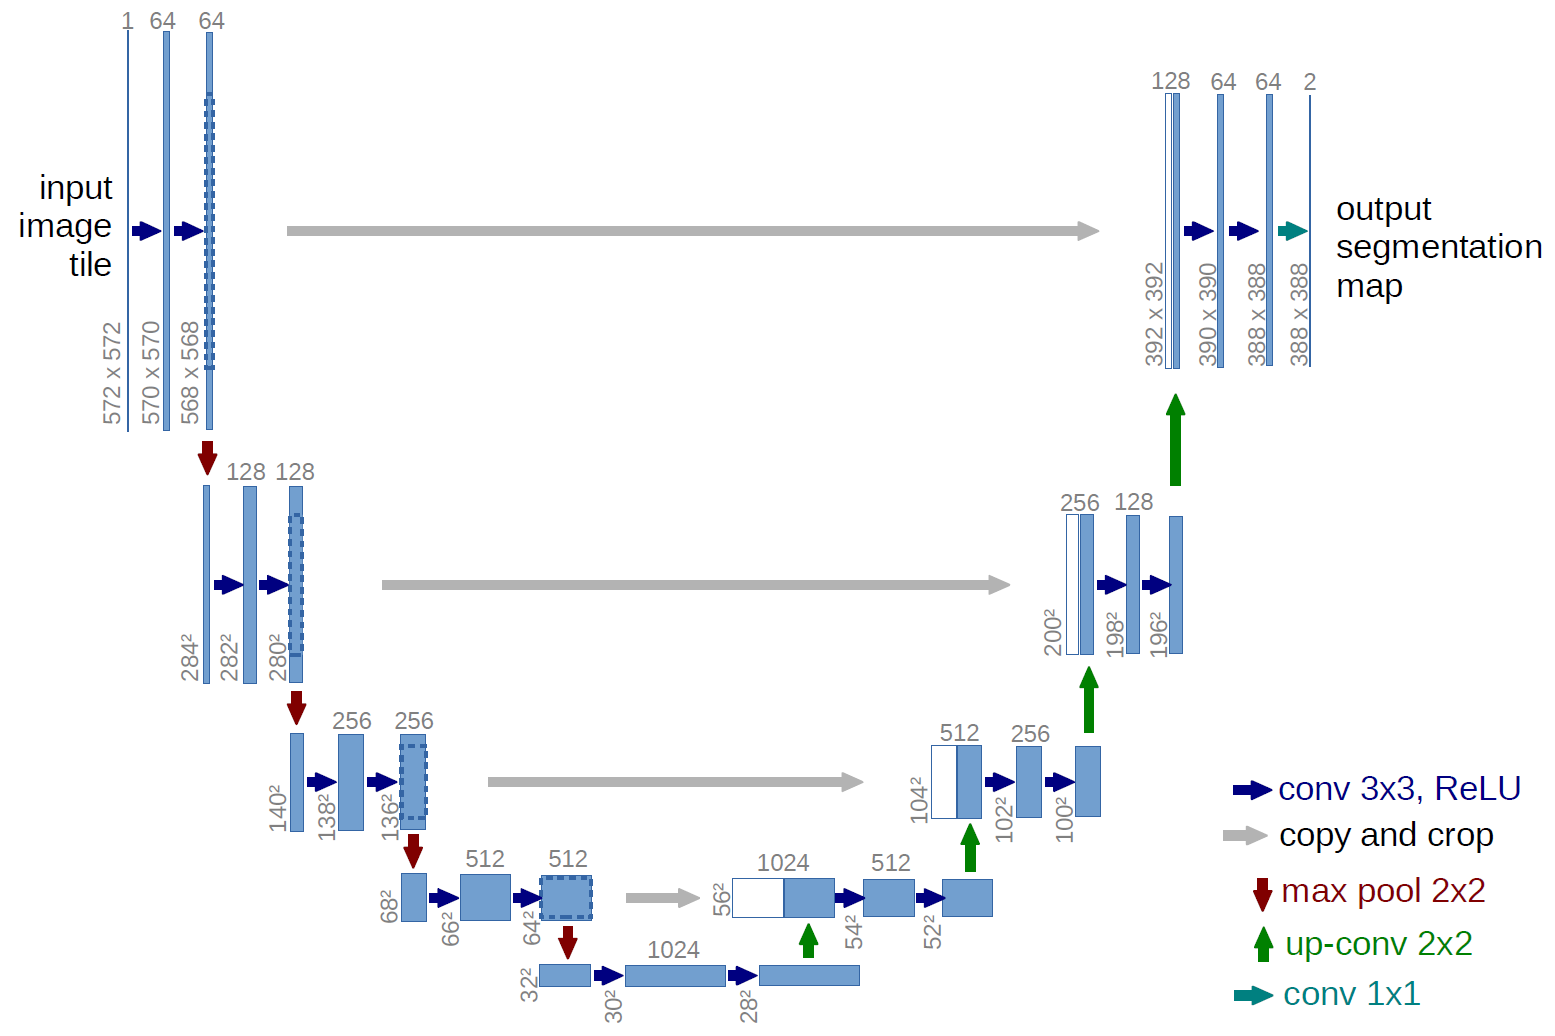

### You can see in the cell below that the code for the UNet network is much cleaner and compact than that of SegNet. This is because here modularity is used and the fact that you can use multiple **nn.Module** class instances within another **nn.Module** instance. Hence, in PyTorch you can first create smaller models and then use those to build up larger models.

## Question 6: Please observe the UNet model below and answer the following questions:

### 6.1: What does the DoubleConv model do? It is built up using the Sequential method of building up models, what is this method?

### 6.2: What operations does the Down module constitute? What is its basic purpose?

### 6.3: What is the purpose of the Up module? What operations does it consists of?

**6.1:**
The DoubleConv model is a building block used in architectures like UNet for image segmentation tasks. It's called "DoubleConv" because it consists of two consecutive operations applied to the input:

Convolutional Layer + Batch Normalization + ReLU Activation: This part performs feature extraction by convolving the input with a kernel to produce a feature map. Batch normalization is applied to stabilize and accelerate training, and ReLU activation introduces non-linearity to the network.

Second Convolutional Layer + Batch Normalization + ReLU Activation: This second set of operations further refines the features extracted in the first step. It's common to stack multiple convolutional layers in deep learning models to learn complex patterns and hierarchies in the data.

**6.2:**
The `Down` module in the provided code constitutes downscaling the input tensor using max pooling followed by a double convolution operation. Its basic purpose is to reduce the spatial dimensions of the input while increasing the number of feature channels, which is a common operation in encoder parts of architectures like UNet used for semantic segmentation tasks.

Here's a breakdown of the operations in the `Down` module:

1. **MaxPooling**: The input tensor is passed through a max pooling layer (`nn.MaxPool2d(2)`), which reduces the spatial dimensions of the input by a factor of 2 in both height and width. Max pooling selects the maximum value from each 2x2 window in the input, effectively downsampling the feature map.

2. **Double Convolution**: After max pooling, the downsampled feature map is passed through the `DoubleConv` module, which consists of two consecutive operations:
   - Convolutional Layer + Batch Normalization + ReLU Activation
   - Second Convolutional Layer + Batch Normalization + ReLU Activation

By combining max pooling for downsampling and double convolution for feature extraction, the `Down` module effectively reduces the spatial dimensions of the input while capturing and refining features that are important for subsequent processing. This downsampling and feature extraction process is typically repeated in the encoder part of architectures like UNet to create a hierarchical representation of the input image, where higher-level features are learned as the spatial dimensions decrease.

**6.3:**
The `Up` module in the provided code is responsible for performing upscaling (transposed convolution or deconvolution) followed by a double convolution operation. Its purpose is to increase the spatial dimensions of the input while reducing the number of feature channels, which is a common operation in decoder parts of architectures like UNet used for semantic segmentation tasks.

Here's a breakdown of the operations in the `Up` module:

1. **Upscaling (Transposed Convolution)**: The input tensor `x1` is passed through a transposed convolution layer (`nn.ConvTranspose2d`) to increase its spatial dimensions. The transposed convolution operation effectively "upsamples" the feature map to a larger size.

2. **Padding**: After upscaling, padding is applied to ensure that the dimensions of the upsampled feature map match those of another input tensor `x2`. This step is crucial for concatenating `x1` and `x2` later in the process.

3. **Concatenation**: The upsampled tensor `x1` is concatenated with another input tensor `x2` along the channel dimension (`dim=1`). This concatenation allows the network to combine high-resolution details from `x1` with semantic information from `x2`.

4. **Double Convolution**: The concatenated tensor is passed through the `DoubleConv` module, which consists of two consecutive operations:
   - Convolutional Layer + Batch Normalization + ReLU Activation
   - Second Convolutional Layer + Batch Normalization + ReLU Activation

By combining upscaling (transposed convolution), concatenation, and double convolution operations, the `Up` module effectively increases the spatial dimensions of the input while refining features and incorporating contextual information from lower-resolution feature maps. This process is crucial for the decoder part of architectures like UNet, where the network reconstructs high-resolution segmentation maps based on the learned features and context from the encoder part.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



""" Full assembly of the parts to form the complete network """
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

model = UNet(3, 5)

# https://github.com/milesial/Pytorch-UNet

## Pretrained Segmentation Models Pytorch
## UNet with MobileNet Encoder

https://github.com/qubvel/segmentation_models.pytorch

### Question 7: The segmentation_models_pytorch is a useful library for using pretrained models for the task of semantic segmentation. If we are using the Unet model, then in this case we can choose between different pre-trained models as the encoder for the UNet. In this cell below we have used "vgg16_bn".Please visit the link given below and mention 3 other encoders listed in the repository.

https://github.com/qubvel/segmentation_models.pytorch

**1.**
ResNet: resnet152

**2.**
Inception: xception

**3.**
Mix Vision Transformer: mit_b5

In [13]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp


model = smp.Unet('vgg16_bn', encoder_weights='imagenet', classes=5, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 753.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:10<00:00, 52.6MB/s]


### Question 8: In the 2 cells given below, we are computing Pixel Accuracy as well as mean Intersection over Union evaluation metrics. Whats the difference between the two? Which one is better and why?

Pixel Accuracy and Mean Intersection over Union (IoU) are both evaluation metrics commonly used in image segmentation tasks to assess the performance of segmentation models. However, they capture different aspects of segmentation accuracy.

1. **Pixel Accuracy**:
   - Pixel Accuracy calculates the percentage of correctly classified pixels in the entire image.
   - It's computed as the ratio of the number of correctly classified pixels to the total number of pixels in the image.
   - Pixel Accuracy is straightforward and easy to interpret, representing the overall correctness of pixel-level predictions.
   - However, it can be misleading for imbalanced datasets where one class dominates the others. For instance, if the majority of pixels belong to one class, a model could achieve high Pixel Accuracy by simply predicting that class for every pixel, even if it performs poorly on other classes.

2. **Mean Intersection over Union (IoU)**:
   - IoU measures the overlap between the predicted segmentation mask and the ground truth mask for each class.
   - It's computed as the ratio of the intersection area between the predicted and ground truth masks to their union.
   - IoU provides a more nuanced evaluation by considering both true positives (correctly classified pixels) and false positives (misclassified pixels).
   - Mean IoU averages the IoU scores across all classes, providing a single metric that reflects the model's segmentation performance across different classes.
   - Mean IoU is particularly useful for evaluating models on imbalanced datasets because it penalizes false positives and rewards accurate segmentation for each class independently.

In terms of which metric is better, it depends on the specific goals and characteristics of the segmentation task:

- **Pixel Accuracy** is simpler and may be sufficient for tasks where class imbalance is not a major concern, and overall pixel-level correctness is more important than class-specific segmentation quality.

- **Mean IoU** is generally preferred for tasks with multiple classes or imbalanced datasets because it provides a more comprehensive evaluation of the model's segmentation performance across different classes. It penalizes misclassifications more effectively and gives a better insight into how well the model distinguishes between classes.

In summary, Mean Intersection over Union (IoU) is often considered a better evaluation metric for image segmentation tasks compared to Pixel Accuracy, especially when dealing with multiple classes or imbalanced datasets, as it provides a more nuanced and class-specific assessment of segmentation quality.

In [14]:
# Calculate pixel accuracy over a batch of images
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [15]:
# Calculate mean Intersection-over-Union over a batch of images
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [16]:
# Inner loop for running the model for 1 epoch over a given loader

def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):

  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0

  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)

  # number of batches we can get by the loader
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):

    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)

    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()

    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows

    # Removing extra last dimension from output tensor
    #output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)

    # Backpropagation
    if train:
      loss.backward()

    # Update the parameters using the gradients
    if train:
      optimizer.step()

    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    #total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(output, labels)
  mean_IoU = mIoU(output, labels)

  return loss, accuracy, mean_IoU

# Tasks:

### 1) Please use the training script below and fine-tune/train the pre-trained UNet-VGG16 encoder model on the cars dataset. Try to experiment with the hyperparameters to achieve maximum validation IoU.

### 2) Use the evaluation script to test the model with best validation mean IoU on the test set and visualize the predicted masks for some of the images.

### 3) Prepare a comprehensive report answering all of the questions posed in this notebook as well as discuss the training plots obtained at the end of the training, and discuss the validation and test results achieved.

# Question 9:
### If you had to use a pretrained encoder other than the VGG16_BN for the UNet model, which one would you prefer to use, and why? (Note: There is no single correct answer to this question. Follow your intuition and current knowledge base that we have developed in the classes.)


If I were to choose a pretrained encoder other than VGG16_BN for the UNet model, I would prefer using the ResNet architecture. Here are a few reasons for this choice:

1. **Residual Connections**: ResNet introduces residual connections, which help alleviate the vanishing gradient problem during training deep networks. This allows for the effective training of very deep networks with hundreds of layers, which can capture more complex features and hierarchies in the data.

2. **State-of-the-Art Performance**: ResNet variants have consistently achieved state-of-the-art performance on various computer vision tasks, including image classification, object detection, and segmentation. This indicates that ResNet-based encoders can capture highly discriminative features and generalize well across different datasets.

3. **Pretrained Models**: Pretrained ResNet models are readily available in popular deep learning libraries like PyTorch and TensorFlow. These models are often pretrained on large-scale datasets like ImageNet, providing a strong starting point for transfer learning on a wide range of tasks.

4. **Efficiency**: ResNet achieves excellent performance with relatively fewer parameters compared to some other deep architectures, making it computationally efficient, especially for resource-constrained environments or when training on large datasets.

5. **Adaptability**: ResNet architectures come in different depths (e.g., ResNet-18, ResNet-34, ResNet-50, etc.), allowing for flexibility in choosing the appropriate model size based on the specific task requirements, computational resources, and trade-offs between model complexity and performance.

Overall, ResNet's architectural innovations, strong performance across various tasks, availability of pretrained models, efficiency, and adaptability make it a compelling choice as a pretrained encoder for the UNet model or other image segmentation tasks.

### Training Configuration

In [17]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 10

model.to(device);

In [18]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

checkpoint_path = '/content/checkpoint.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint.pth'

# Start epoch is zero for new training
start_epoch = 0

### Main training loop

In [19]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy, train_mIoU  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)

  # Lists for val loss and accuracy for plotting
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  # writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  # writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  print('train_IoU %.2f'%(train_mIoU))
  print('val_IoU %.2f'%(val_mIoU))

  # Save model if validation accuracy for current epoch is greater than
  # all the previous epochs
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)



Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.8403
val loss: 1.4762
train_accuracy 0.89
val_accuracy 0.54
train_IoU 0.47
val_IoU 0.21
New max val mean IoU Acheived 0.21. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.3493
val loss: 0.4177
train_accuracy 0.92
val_accuracy 0.91
train_IoU 0.60
val_IoU 0.48
New max val mean IoU Acheived 0.48. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.2384
val loss: 0.2153
train_accuracy 0.92
val_accuracy 0.93
train_IoU 0.60
val_IoU 0.61
New max val mean IoU Acheived 0.61. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.1879
val loss: 0.1675
train_accuracy 0.95
val_accuracy 0.94
train_IoU 0.67
val_IoU 0.67
New max val mean IoU Acheived 0.67. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.1577
val loss: 0.1221
train_accuracy 0.95
val_accuracy 0.96
train_IoU 0.67
val_IoU 0.70
New max val mean IoU Acheived 0.70. Saving model.


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.1280
val loss: 0.1468
train_accuracy 0.97
val_accuracy 0.97
train_IoU 0.72
val_IoU 0.71
New max val mean IoU Acheived 0.71. Saving model.


Epoch 6: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.1078
val loss: 0.1033
train_accuracy 0.97
val_accuracy 0.97
train_IoU 0.72
val_IoU 0.69
val mean IoU did not increase from 0.71


Epoch 7: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.1019
val loss: 0.0895
train_accuracy 0.96
val_accuracy 0.96
train_IoU 0.73
val_IoU 0.72
New max val mean IoU Acheived 0.72. Saving model.


Epoch 8: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0891
val loss: 0.0842
train_accuracy 0.97
val_accuracy 0.96
train_IoU 0.81
val_IoU 0.80
New max val mean IoU Acheived 0.80. Saving model.


Epoch 9: Train 
Learning Rate: 0.001000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.0790
val loss: 0.0806
train_accuracy 0.97
val_accuracy 0.97
train_IoU 0.81
val_IoU 0.78
val mean IoU did not increase from 0.80




Text(0.5, 1.0, 'Training and val mIoU')

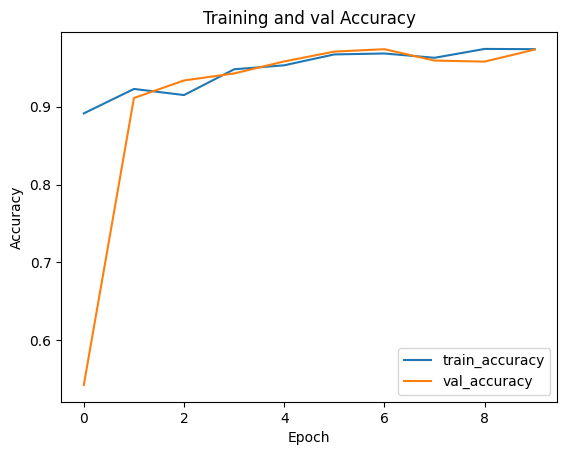

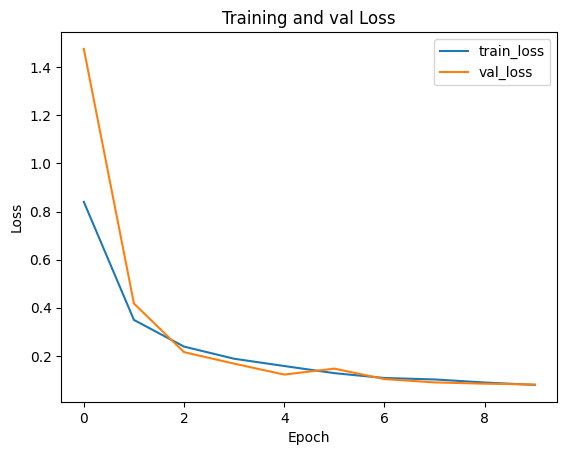

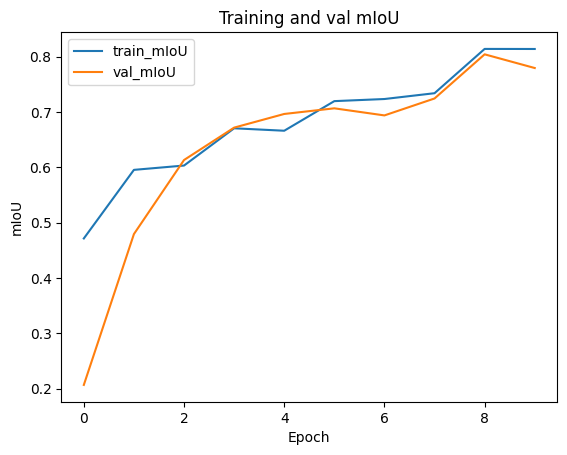

In [20]:
plt.figure()
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(val_accuracies, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

plt.figure()
plt.plot(train_mIoUs, label="train_mIoU")
plt.plot(val_mIoUs, label="val_mIoU")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and val mIoU')

# Evaluation

In [21]:
best_val_model_path = '/content/best_val_checkpoint.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
# Before loading the state_dict of the model, make sure the "model" instance is
# initiated by its corresponding class e.g. VGG16
model.load_state_dict(best_val_checkpoint['model'])

<All keys matched successfully>

### Question 10: Why are we creating the CarsTestDataset class? Why not use the same dataset class that we had defined earlier? What is the difference between the two?

The `CarsTestDataset` class is created specifically for testing purposes, which might involve different requirements or processing compared to the training or validation datasets. Here are some reasons why we might create a separate dataset class for testing:

1. **Different Transformations**: During testing, we may want to apply different transformations or preprocessing steps compared to training. For example, we might resize images differently or omit certain augmentations that are used during training to ensure that the model is evaluated on raw or minimally processed data.

2. **No Ground Truth Labels**: In many testing scenarios, we don't have ground truth labels available (e.g., in real-world applications or when evaluating on a separate test set). Therefore, the testing dataset class may not need to handle masks or ground truth labels, unlike the training dataset class.

3. **Efficiency and Speed**: By creating a separate dataset class for testing, we can optimize the data loading and processing pipeline specifically for testing requirements. This can improve efficiency and reduce unnecessary computations, especially when dealing with large test sets or when evaluating multiple models.

4. **Modularity and Organization**: Separating the testing dataset class from the training dataset class promotes modularity and organization in the codebase. It keeps the code cleaner and easier to maintain, especially when there are distinct differences in how training and testing data are handled.

5. **Flexibility**: Having separate dataset classes allows for flexibility in experimentation and evaluation. We can easily switch between different dataset configurations (training, validation, testing) without modifying the core dataset class repeatedly.

The main difference between the `CarsDataset` class (used for training and validation) and the `CarsTestDataset` class (used for testing) is their purpose and handling of data. While the training dataset class typically includes ground truth labels, complex transformations, and augmentation pipelines, the testing dataset class focuses on providing raw or processed data for evaluating the model's performance without ground truth labels or with minimal processing. This separation helps ensure that the testing process is independent and unbiased, providing reliable insights into the model's generalization and performance on unseen data.

In [22]:
class CarsTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = CarsTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [23]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [24]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [25]:
mob_miou = test_miou_score(model, test_set)
np.mean(mob_miou)

  0%|          | 0/22 [00:00<?, ?it/s]

0.7337434013673857

In [26]:
def display_for_comparison(image, mask, pred_mask):

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-VGG16_BN | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

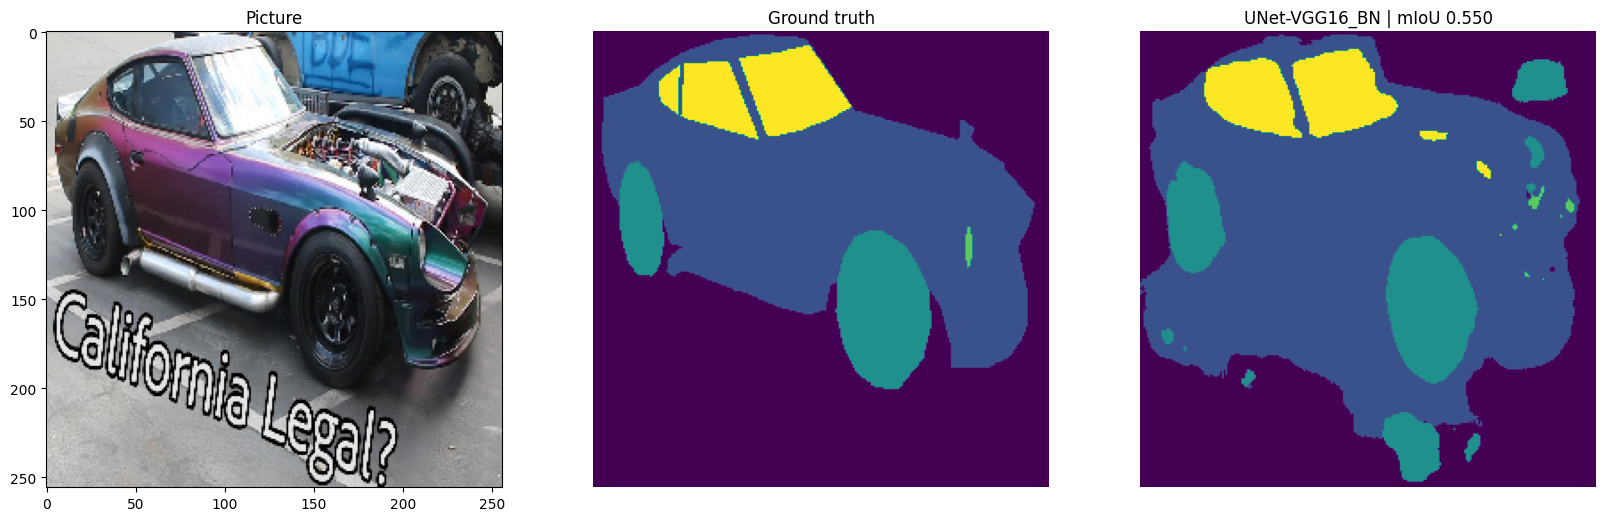

In [27]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

display_for_comparison(image, mask, pred_mask)

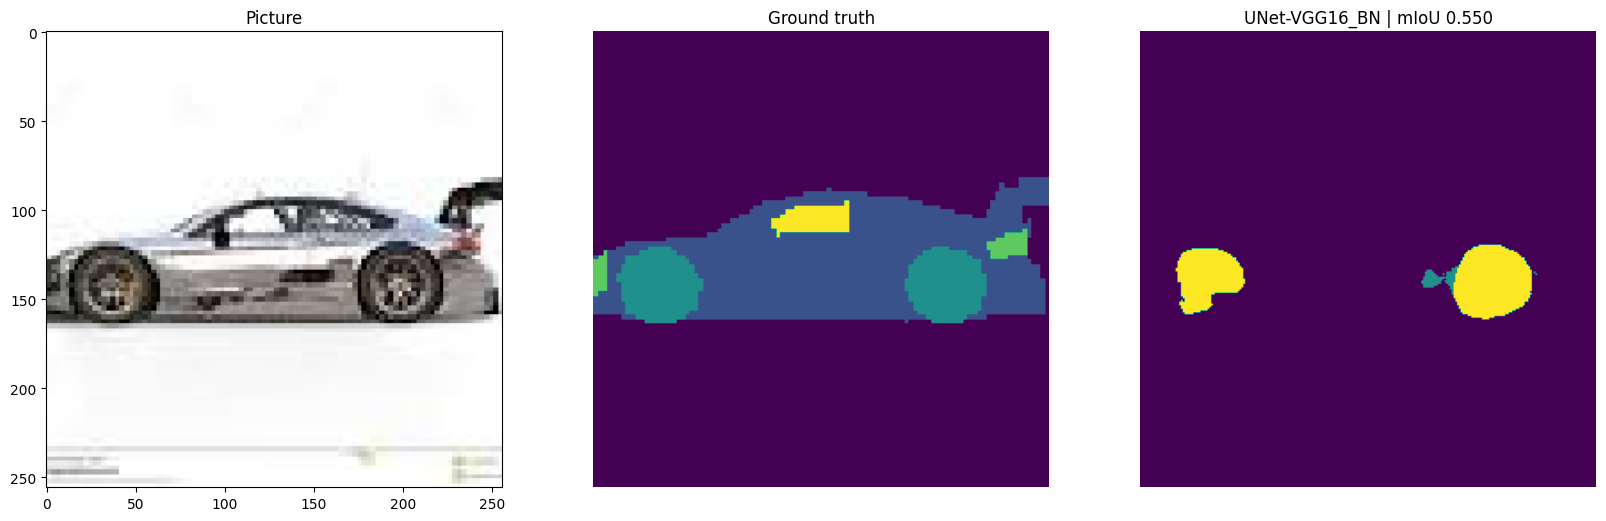

In [28]:
image2, mask2 = test_set[9]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)


display_for_comparison(image2, mask2, pred_mask2)

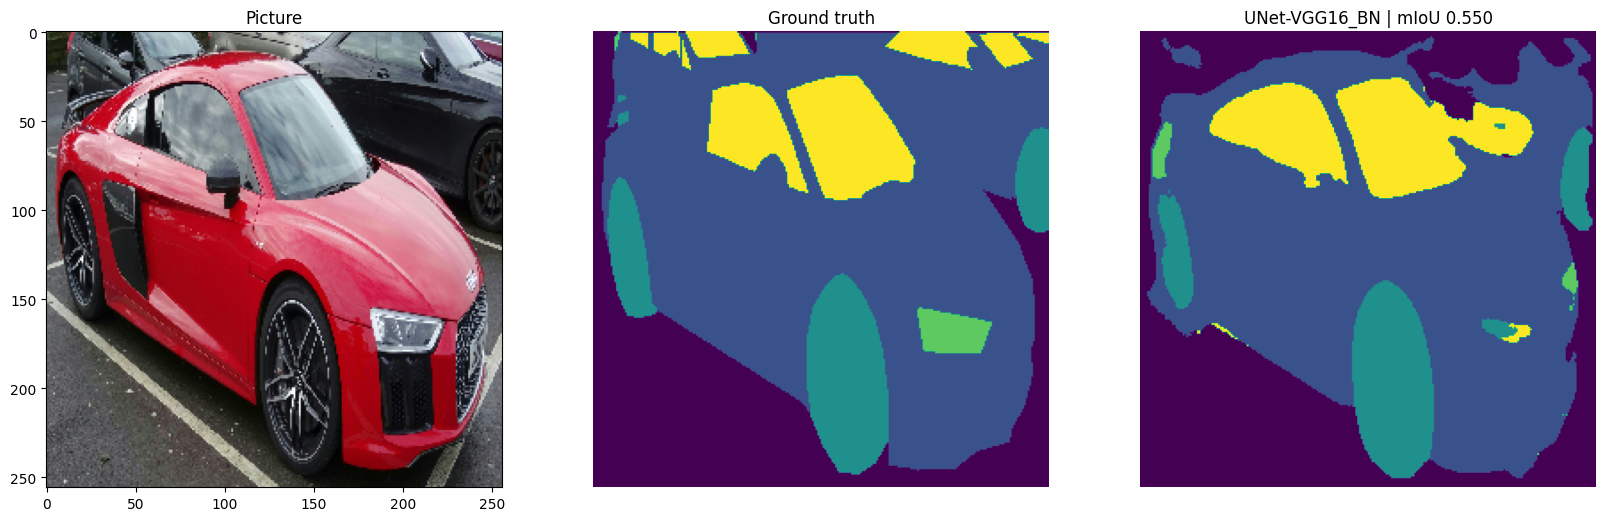

In [29]:
image3, mask3 = test_set[15]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)


display_for_comparison(image3, mask3, pred_mask3)

# Deliverable

1. Submit a your notebook with complete code and output.
2. In the same notbook clearly mention the answers to each question and perform analysis when and where required
3. Its an individual lab. Plagarism is not allowed.

# Sources
- https://github.com/Vision-At-SEECS/Pytorch_Labs/blob/main/Lab4_Semantic_Segmentation.ipynb
- https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch